# Unbalanced Data in Credit: Generative Adversarial Network
This notebook compares different approach for dealing unbalanced data in credit domain. \
References:
- https://towardsdatascience.com/generative-ai-synthetic-data-generation-with-gans-using-pytorch-2e4dde8a17dd
- https://medium.com/@tanayagrawal/train-your-first-gan-model-from-scratch-using-pytorch-9b72987fd2c0

In [ ]:
!pip install kaggle

In [ ]:
from dotenv import load_dotenv
load_dotenv()

import kaggle as kg
import pandas as pd
import numpy as np
import re
import string
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)
from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu

import warnings
warnings.filterwarnings("ignore")
# Visulalization
%matplotlib inline
matplotlib.rc(("xtick", "ytick", "text"), c="k")
matplotlib.rc("figure", dpi=80)

# Packages options
sns.set(rc={'figure.figsize': [14, 7]}, font_scale=1.2) # Standard figure size for all
np.seterr(divide='ignore', invalid='ignore', over='ignore') ;


import torch
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import torch.nn.init as init
from torch.utils.data import Dataset


kg.api.authenticate()

## Download Dataset

In [ ]:
DATASET_NAME = "parisrohan/credit-score-classification"

In [ ]:
kg.api.dataset_download_files(dataset=DATASET_NAME, path='on.zip', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/parisrohan/credit-score-classification


In [ ]:
df_train = pd.read_csv('on.zip/train.csv', encoding='ISO-8859-1')
df_train["is_train"] = True

df_test = pd.read_csv('on.zip/test.csv', encoding='ISO-8859-1')
df_test["is_train"] = False

## Data Cleaning and Preprocessing
These activities are beyond the scope of this exercise. We use this [notebook](https://www.kaggle.com/code/duleeppanthagani/creditscoreevaluation) for data cleaning and preprocessing. To avoid data leakage, where information from the test set influences the training process, we process train and test sets separately.

In [ ]:
# Dropping irrelevant columns
df_train.drop(["Name", "SSN", "ID"], axis=1, inplace=True, errors="ignore")
df_test.drop(["Name", "SSN", "ID"], axis=1, inplace=True, errors="ignore")

# Change dtype for specific columns
columns_to_convert = ["Month", "Occupation", "Type_of_Loan", "Credit_History_Age", "Payment_Behaviour"]
df_train[columns_to_convert] = df_train[columns_to_convert].astype("category")
df_test[columns_to_convert] = df_test[columns_to_convert].astype("category")

### Data Preprocessing

In [ ]:
class DataProcessor:
    def __init__(self, groupby, data_frame):
        self.groupby = groupby
        self.df = data_frame

    def get_month(self, x):
     if not pd.isnull(x):
         year_month = re.findall(r"\d+", x)
         months = (int(year_month[0])*12) + np.int64(year_month[-1])
         return months
     else:
         x

    @staticmethod
    def get_numbers(text):
        digits = re.findall(r'\d+', str(text))
        digits = ','.join(digits)
        return digits

    @staticmethod
    def replace_special_character(text):
        if "NM" in str(text):
            return "No"
        if "payments" in str(text) or "_" not in str(text):
            return text
        clean_text = str(text).replace("_", "")
        return np.nan if clean_text == "nan" else clean_text

    @staticmethod
    def preprocess_text(texts:str) -> tuple[dict, list[list[str]]]:
        dictionary = {}
        tokens = [str(text).lower().replace("and", "").split(",") for text in texts]
        tokens = [[token.strip() for token in token_list if token not in string.punctuation] for token_list in tokens]
        for token_list in tokens:
            for token in token_list:
                if token not in dictionary:
                    size = len(dictionary)
                    dictionary[token] = size
        return (dictionary, ["|".join(words) for words in tokens])


    def fill_na(self, df: pd.DataFrame):
        cat_features = df.select_dtypes(exclude="number").columns.drop(
            ["Type_of_Loan", "is_train"])
        num_features = df.select_dtypes(include="number").columns
        df["Type_of_Loan"].fillna("not specified", inplace=True)
        if "Credit_Score" in df.columns:
            cat_features = cat_features.drop("Credit_Score")
        imputer_mode = SimpleImputer(strategy='most_frequent')
        imputer_mode.fit(df[cat_features])
        data_imputed_mode = imputer_mode.transform(df[cat_features])
        df[cat_features] = data_imputed_mode

        imputer_median = SimpleImputer(strategy='median')
        imputer_median.fit(df[num_features])
        data_imputed_median = imputer_median.transform(df[num_features])
        df[num_features] = data_imputed_median
        return df



    def preprocess(self):
        # Age
        self.df['Age'] = self.df.Age.apply(DataProcessor.get_numbers)
        # Handle Special Characters
        self.df = self.df.applymap(DataProcessor.replace_special_character)
        self.df = self.df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
        # Credit Mix
        self.df["Credit_Mix"] = self.df.groupby(self.groupby)["Credit_Mix"].transform(lambda x: x.replace("", x.mode()[0]))
        # Payment Behaviour
        self.df["Payment_Behaviour"] = self.df.groupby(self.groupby)["Payment_Behaviour"].transform(
            lambda x: x.replace("!@9#%8", x.mode()[0])
        )
        self.df["Payment_Behaviour"] = self.df["Payment_Behaviour"].transform(
            lambda x: x.replace("!@9#%8", x.mode()[0])
        )
        # Type of Loan
        self.df["Type_of_Loan"] = self.df[["Type_of_Loan"]].apply(lambda x:  DataProcessor.preprocess_text(x.values)[-1])
        self.df["Type_of_Loan"] = self.df["Type_of_Loan"].str.replace(" ", "_").str.replace("|", " ").replace("nan", np.nan)
        # Credit History Age
        self.df["Credit_History_Age"] = self.df["Credit_History_Age"].apply(lambda x: self.get_month(x))
        # Monthly Balance
        self.df["Monthly_Balance"] = pd.to_numeric(self.df.Monthly_Balance, errors="coerce")
        # Replacing account balances less than zero with zero
        self.df.loc[self.df["Num_Bank_Accounts"] < 0, "Num_Bank_Accounts"] = 0
        # Replace "nan" values in the 'Type_of_Loan' column with NaN for consistency
        self.df.loc[self.df["Type_of_Loan"] == "nan", "Type_of_Loan"] = np.nan
        # Replace "nan" values in the 'Occupation' column with NaN for consistency
        self.df.loc[self.df["Occupation"] == "", "Occupation"] = np.nan
        self.df.loc[self.df["Occupation"] == "_______", "Occupation"] = np.nan
        # Replace "nan" values in the 'Credit_Mix' column with NaN for consistency
        self.df.loc[self.df["Credit_Mix"] == "", "Credit_Mix"] = np.nan

        # Negetive Numbers
        self.df['Num_of_Delayed_Payment'] = pd.to_numeric(self.df['Num_of_Delayed_Payment'], errors='coerce')

        self.df.loc[self.df['Num_of_Delayed_Payment'] < 0, 'Num_of_Delayed_Payment'] = np.nan
        self.df.loc[self.df['Delay_from_due_date'] < 0, 'Delay_from_due_date'] = np.nan

        # Filling missing values
        self.df = self.fill_na(self.df)

        return self.df

In [ ]:
preprocesor_train = DataProcessor("Customer_ID", df_train)
df_train = preprocesor_train.preprocess()

In [ ]:
preprocesor_test = DataProcessor("Customer_ID", df_test)
df_test = preprocesor_test.preprocess()

In [ ]:
class ClipOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 lower_quantile,
                 upper_quantile,
                 multiply_by=1.5,
                 replace_with_median: bool = False):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.multiply_by = multiply_by
        self.replace_with_median = replace_with_median

        self.lower_limit = 0
        self.upper_limit = 0
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        q1, q3 = np.quantile(X, [self.lower_quantile, self.upper_quantile])
        iqr = q3 - q1
        self.lower_limit = q1 - (self.multiply_by * iqr)
        self.upper_limit = q3 + (self.multiply_by * iqr)
        return self

    def transform(self, X):
        if self.replace_with_median:
            return np.where(
                ((X >= self.lower_limit) & (X <= self.upper_limit)), X,
                np.median(X))
        else:
            return np.clip(X, self.lower_limit, self.upper_limit)


def get_skewness(df, lower=None, upper=None):
    columns = df.columns
    skewness: pd.Series = df[columns].skew()
    highly_skewed = skewness[(skewness <= lower) |
                             (skewness >= upper)].index.to_list()
    lowly_skewed = skewness[(skewness > lower)
                            & (skewness < upper)].index.to_list()
    return (highly_skewed, lowly_skewed)


def remove_outliers(df: pd.DataFrame):
    if "Credit_Score" in df.columns:
      category = df.select_dtypes(exclude="number").columns.drop(
          ["Credit_Score", "is_train"])
    else:
      category = df.select_dtypes(exclude="number").columns.drop(
          ["is_train"])
    numbers = df.select_dtypes(include="number").columns

    highly_skewed, lowly_skewed = get_skewness(df[numbers],
                                               lower=-0.8,
                                               upper=0.8)

    df[highly_skewed] = df[highly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=True).
        fit_transform(x))

    df[lowly_skewed] = df[lowly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=False).
        fit_transform(x))
    return df

In [ ]:
df_train = remove_outliers(df_train)
df_test = remove_outliers(df_test)

### Data Visualization

In [ ]:
# Visualization Super Class
def make_boxplot(df, column, ax):
    sns.boxplot(x="Credit_Score", y=column, data=df, ax=ax, width=0.8, palette="Set2")
    plt.xticks(rotation=90)
    # add the five number summary to the plot
    plt.title(column, fontdict={"fontsize": 15})
    plt.xticks(rotation=0)

def plot_boxplot_num_cols(df):
    fig = plt.figure(figsize=(18, 18), dpi=300)
    numb_columns = df.select_dtypes(include="number").columns
    for column in numb_columns:
        ax = fig.add_subplot(5, 4, list(numb_columns).index(column)+1)
        make_boxplot(df, column, ax)
        plt.tight_layout(pad=0.3)
    plt.tight_layout()
    plt.show()

# Define function to create histograms for all numeric features
def plot_histograms(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    num_cols = len(numeric_cols)
    num_plots_per_row = 3
    num_rows = (num_cols // num_plots_per_row) + (num_cols % num_plots_per_row > 0)

    fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 10))
    axes = axes.ravel()

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], bins=20, kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

        if i >= num_cols - 1:
            for j in range(i + 1, len(axes)):
                axes[j].remove()
            break

    plt.tight_layout()
    plt.show()

# Define function to create Distribution plot for all numeric features
def plot_distribution_plots(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    num_cols = len(numeric_cols)
    num_plots_per_row = 3
    num_rows = (num_cols // num_plots_per_row) + (num_cols % num_plots_per_row > 0)

    fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 10))
    axes = axes.ravel()

    for i, col in enumerate(numeric_cols):
        sns.distplot(df[col], bins=20, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')

        if i >= num_cols - 1:
            for j in range(i + 1, len(axes)):
                axes[j].remove()
            break

    plt.tight_layout()
    plt.show()

def make_countplot(df: pd.DataFrame):
    cat_cols = df.select_dtypes(exclude="number").columns.drop(
        ['Credit_Score','Customer_ID', "Type_of_Loan"])
    cat_cols = list(cat_cols)
    cat_cols.pop(-1)
    cat_cols.insert(-2, "Payment_Behaviour")

    fig, axes = plt.subplots(figsize=(12, 12), dpi=300)
    fig.suptitle("Counts of categorical columns")
    axes.grid(visible=False)
    axes.xaxis.set_tick_params(labelbottom=False)
    axes.yaxis.set_tick_params(labelleft=False)

    def __plot_graph(df, col, ax: plt.Axes, legend=False):
        sns.countplot(
            data=df,
            x=col,
            ax=ax,
            hue="Credit_Score",
        )
        # label =ax.get_xlabel()
        ax.set_xlabel(col, fontdict={"size": 9})
        ax.set_title(f"by {col}", fontdict={"size": 9})
        ax.get_xticklabels()
        ax.tick_params(labelsize=7, axis="y")
        ax.set_xticklabels(ax.get_xticklabels(),
                           rotation=90,
                           fontdict=dict(size=7))
        ax.grid(False)
        if legend:
            ax.legend(shadow=True,
                      loc="best",
                      facecolor="inherit",
                      frameon=True)
        else:
            ax.legend_ = None
        plt.tight_layout(w_pad=1)

    for i, col in enumerate(cat_cols, 1):
        if i == 3:
            continue
        ax = fig.add_subplot(2, 3, i)
        __plot_graph(df, col=col, ax=ax)

    ax2 = fig.add_axes((0.74, 0.527, 0.23, 0.35))
    __plot_graph(df, col="Payment_Behaviour", ax=ax2, legend=True)
    plt.show(True)

def plot_correlation_matrix(data):
    corr = data.corr(numeric_only=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig = plt.figure(figsize=(10, 10), dpi=150)

    sns.heatmap(corr, annot=True, mask=mask, fmt=".0%", annot_kws={"size":10})
    plt.grid(False)
    plt.tick_params(axis="both", labelsize=5)
    plt.tight_layout()
    plt.title("Correlation Matrix")
    plt.show()

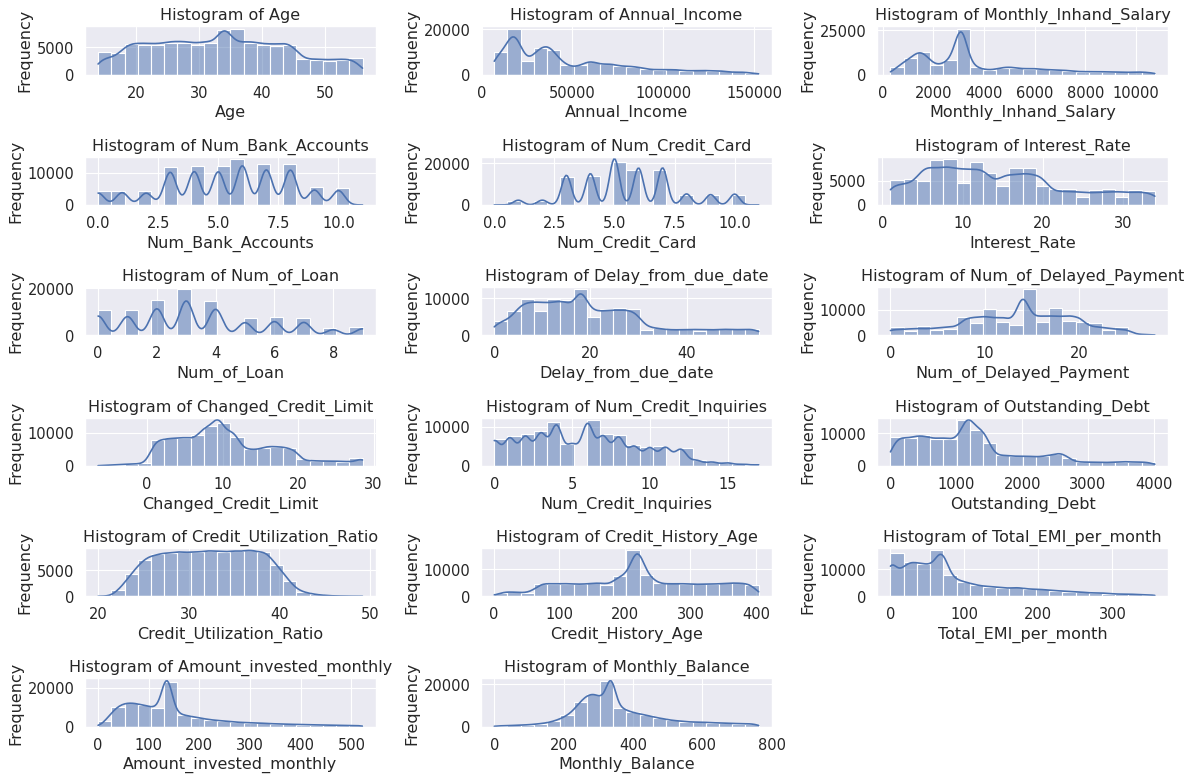

In [ ]:
plot_histograms(df_train)

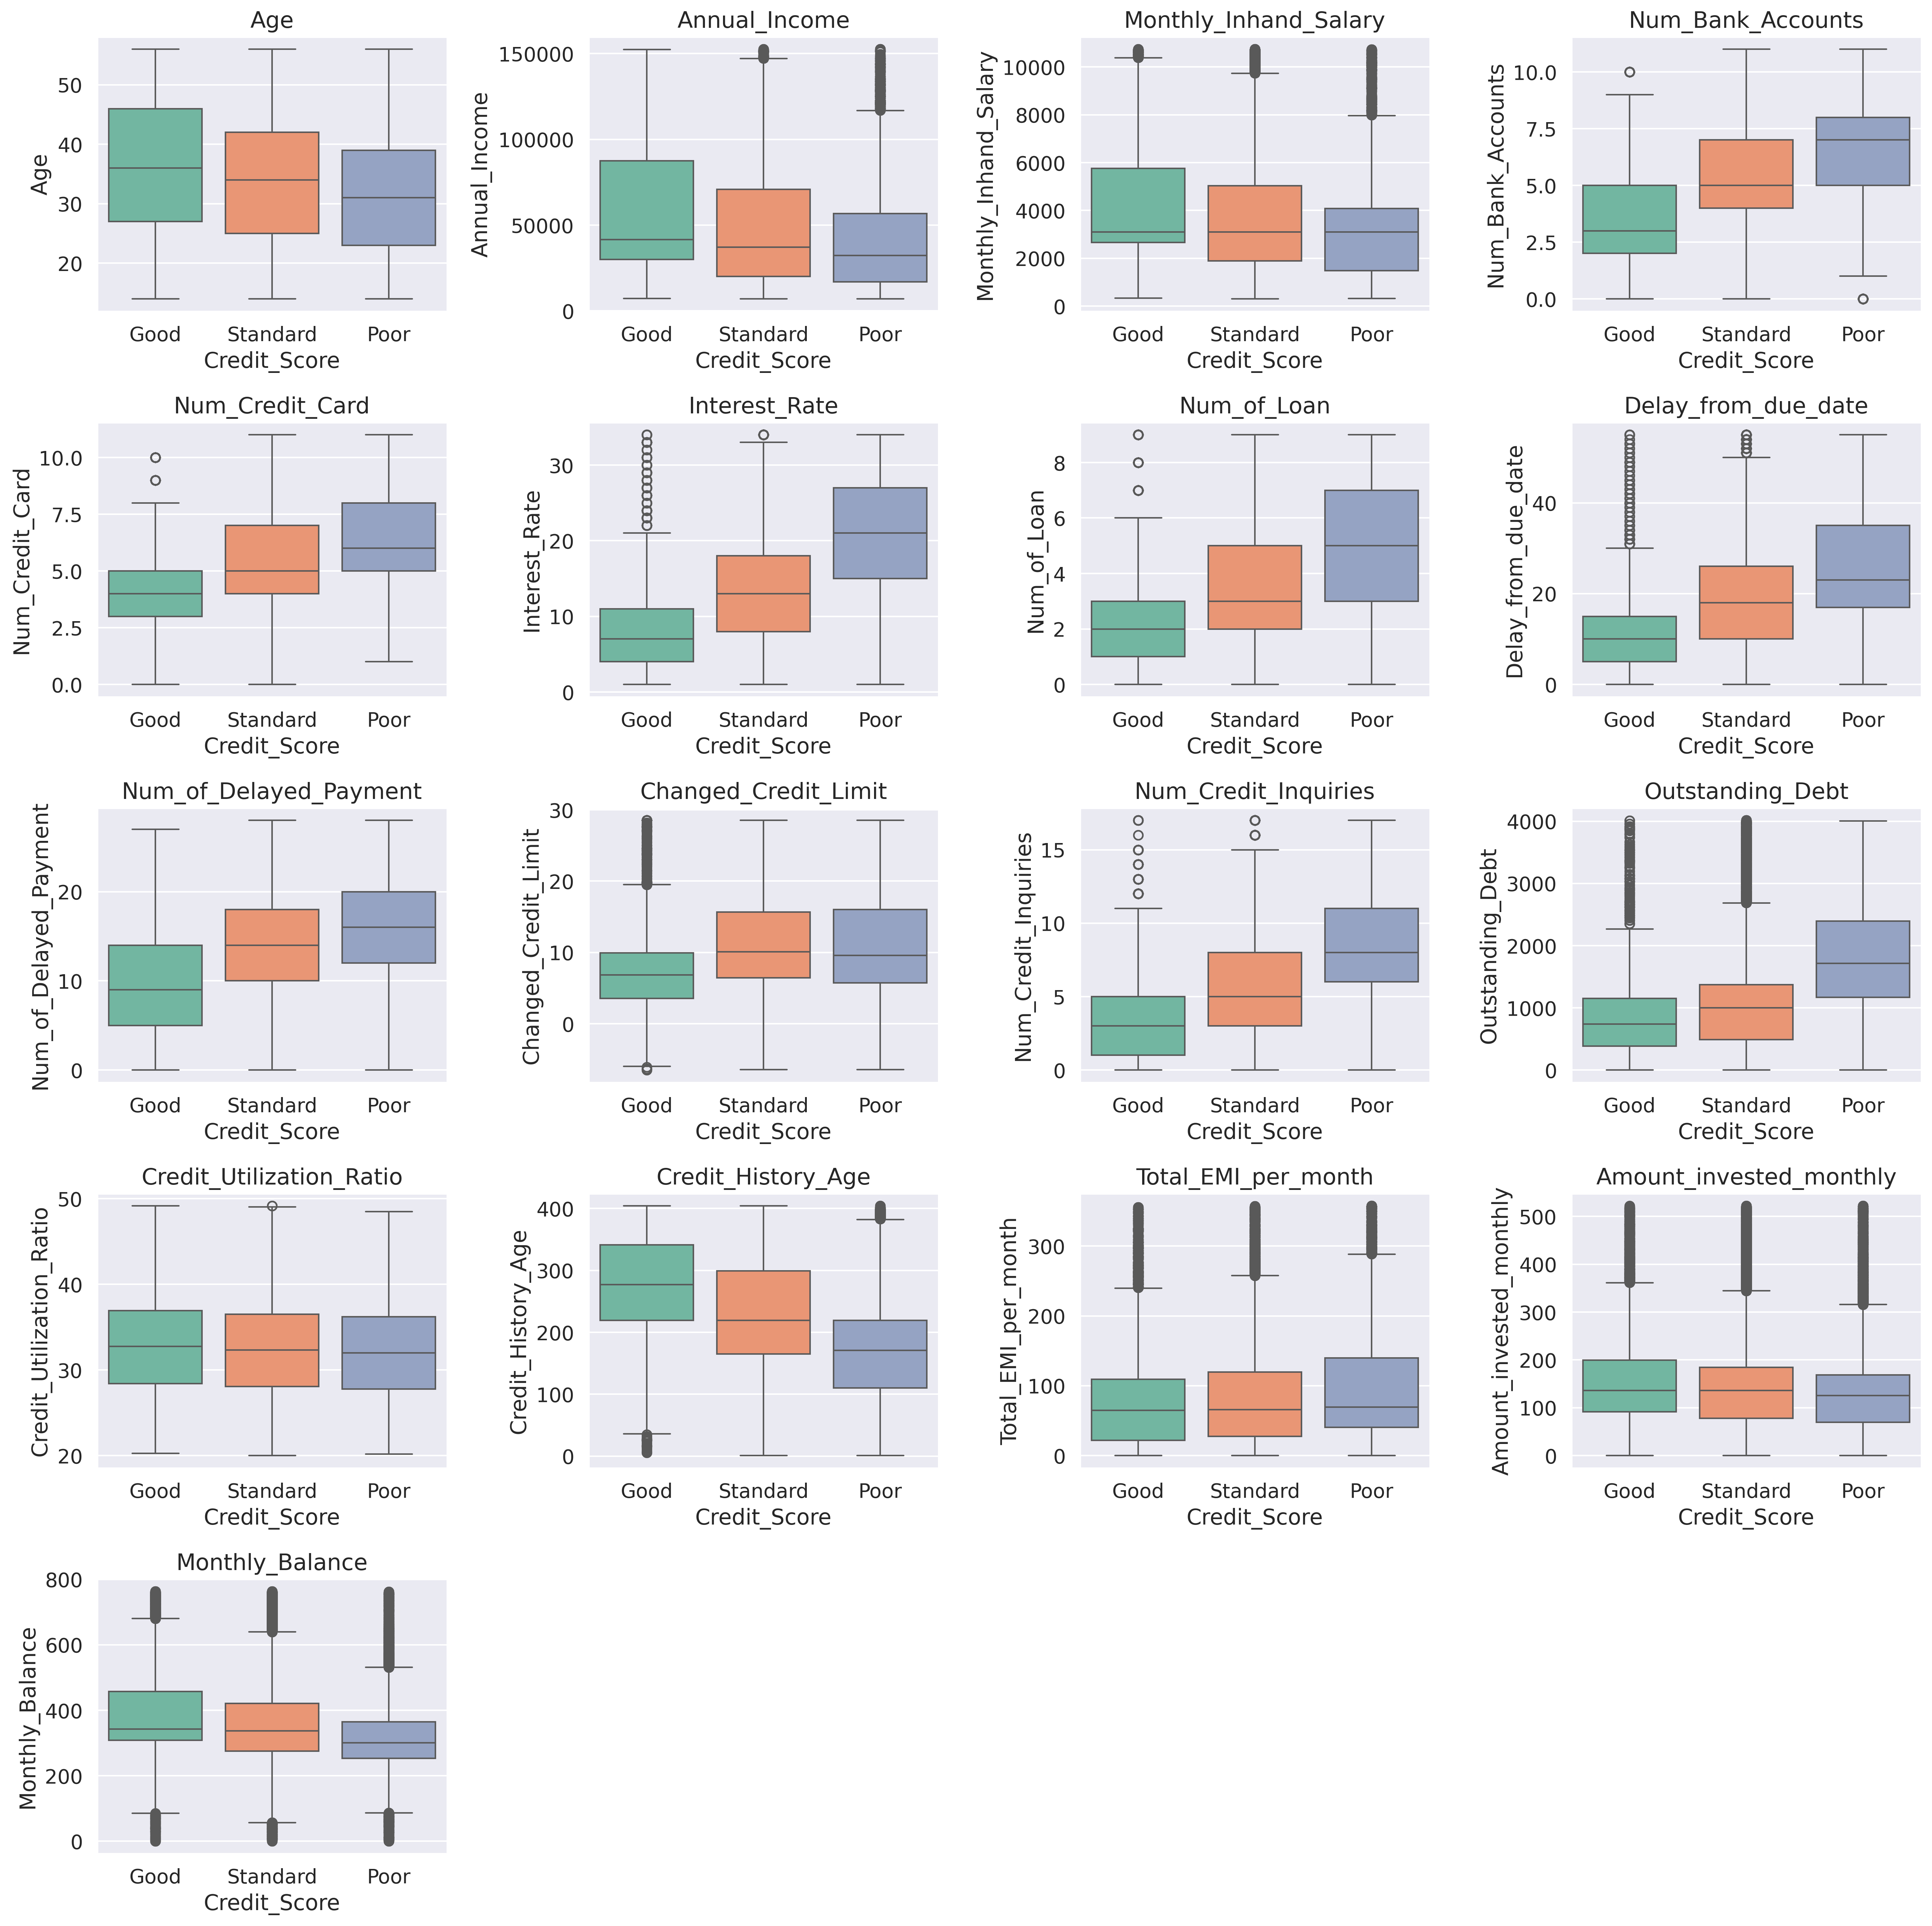

In [ ]:
plot_boxplot_num_cols(df_train)

### Feature Engineering

In [ ]:
def feature_engineering(df):
    # Define mappings for categorical variables

    credit_score_mapping = {
        "Poor": 0,
        "Standard": 1,
        "Good": 2
    }

    credit_mix_mapping = {
        "Bad": 0,
        "Standard": 1,
        "Good": 2
    }

    min_amount_mapping = {
        "Yes": 1,
        "No": 0
    }

    # Replace categorical variables with mapped values

    if 'Credit_Score' in df:
      df['Credit_Score'].replace(credit_score_mapping, inplace=True)
    df['Credit_Mix'].replace(credit_mix_mapping, inplace=True)
    df['Payment_of_Min_Amount'].replace(min_amount_mapping, inplace=True)

    # Perform one-hot encoding for selected categorical variables

    df = pd.get_dummies(df, columns=['Occupation', 'Payment_Behaviour'], dtype=float)

    # Drop unnecessary columns

    df = df.drop(['Customer_ID', 'Month', 'Type_of_Loan', 'is_train'], axis=1)

    return df

In [ ]:
df_train = feature_engineering(df_train)
df_train["Credit_Score"].value_counts(normalize=True)

Credit_Score
1    0.53174
0    0.28998
2    0.17828
Name: proportion, dtype: float64

In [ ]:
df_test = feature_engineering(df_test)

## Modeling
We train XGBoost model. Minority classes are oversampled via SMOTE

In [ ]:
X_train, y_train = df_train.drop(columns=["Credit_Score", "Credit_Mix"]).values , df_train["Credit_Score"]
X_test = df_test.drop(columns=["Credit_Mix"]).values
assert X_train.shape[1] == X_test.shape[1]

rus = SMOTE(sampling_strategy='auto')
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
y_train_rus.value_counts(normalize=True)

Credit_Score
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_rus, y_train_rus, test_size=0.2, random_state=42,stratify=y_train_rus)

In [ ]:
scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_val = scalar.transform(X_val)

In [ ]:
res = dict()

model = XGBClassifier(n_jobs=-1)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

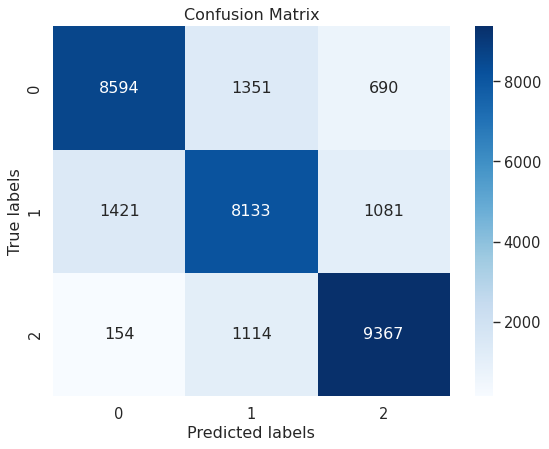

,0,1,2,accuracy,macro avg,weighted avg
precision,0.845118,0.767409,0.840995,0.817866,0.817840,0.817840
recall,0.808087,0.764739,0.880771,0.817866,0.817866,0.817866
f1-score,0.826187,0.766072,0.860423,0.817866,0.817561,0.817561
support,10635.000000,10635.000000,10635.000000,0.817866,31905.000000,31905.000000


In [ ]:
report = classification_report(y_val, y_pred, output_dict=True)
res["precision"] = report["weighted avg"]["precision"]
res["recall"] = report["weighted avg"]["recall"]
res["f1_score"] = report["weighted avg"]["f1-score"]
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

report_df = pd.DataFrame(report)
report_df

## Synthetic Data Generation via GAN
We generate synthetic data of minority classes (i.e. Poor and Good scores) via Generative Adversarial Network

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(256),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(512),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
#Creating a dataset

class MyDataset(Dataset):
    def __init__(self, data: np.ndarray):
        self.data = data.astype(float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        return sample


In [ ]:
import torch.optim as optim

# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 200
lr_gen = 1e-5
lr_dis = 1e-5

# Other params
noise_dim = 39
num_features = 39
latent_dim  = noise_dim

critic_iterations = 5
weight_clip = 0.01

def make_some_noise(BATCH_SIZE,noise_dim):
    return torch.randn(BATCH_SIZE,noise_dim)

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

generator = Generator(noise_dim, num_features)
discriminator = Discriminator(num_features)

generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)

In [ ]:
criterion = nn.BCELoss()
# gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
# disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_dis, betas=(0.5, 0.999))

gen_optimizer = torch.optim.RMSprop(generator.parameters(), lr=lr_gen)
disc_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=lr_dis)

### Poor Score (class = 0) Training

In [ ]:
class_id = 0
X_train = df_train.query("Credit_Score==@class_id").drop(columns=["Credit_Score", "Credit_Mix"]).values
scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)

In [ ]:
# Create an instance of the dataset
dataset_poor = MyDataset(X_train)

# Create DataLoader
dataloader_poor = DataLoader(dataset_poor, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
gen_loss_list = []
dis_loss_list = []

for epoch in range(EPOCHS):
    for batch in tqdm(dataloader_poor, total=len(dataloader_poor)):
        # Train Discriminator (Critic) more iterations than Generator
        for _ in range(critic_iterations):
            disc_optimizer.zero_grad()
            real_data = batch
            fake_data = generator(make_some_noise(BATCH_SIZE, latent_dim)).detach()

            real_validity = discriminator(real_data)
            fake_validity = discriminator(fake_data)

            # Wasserstein loss for discriminator
            d_loss = -(torch.mean(real_validity) - torch.mean(fake_validity))
            d_loss.backward()
            disc_optimizer.step()

            # Clip weights of discriminator
            for p in discriminator.parameters():
                p.data.clamp_(-weight_clip, weight_clip)

        # Train Generator
        gen_optimizer.zero_grad()
        gen_data = generator(make_some_noise(BATCH_SIZE, latent_dim))
        g_loss = -torch.mean(discriminator(gen_data))
        g_loss.backward()
        gen_optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
    gen_loss_list.append(g_loss.item())
    dis_loss_list.append(d_loss.item())
# Plot the losses

plt.figure(figsize=(10, 5))
plt.plot(gen_loss_list, label="Generator Loss")
plt.plot(dis_loss_list, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 1/200, D Loss: -0.0005270156543701887, G Loss: 1.4822217053733766e-06


  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 2/200, D Loss: -0.001592444023117423, G Loss: -0.0004114028997719288


  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 3/200, D Loss: -0.001085023395717144, G Loss: -8.01745627541095e-05


  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 4/200, D Loss: -0.0009666503174230456, G Loss: -0.0002818761277012527


  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 5/200, D Loss: -0.0006714887567795813, G Loss: -0.00028657590155489743


  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 6/200, D Loss: -0.0006114254938438535, G Loss: -0.00035392571589909494


  0%|          | 0/1812 [00:00<?, ?it/s]

Epoch 7/200, D Loss: -0.0006356570520438254, G Loss: -0.00031881488393992186


  0%|          | 0/1812 [00:00<?, ?it/s]

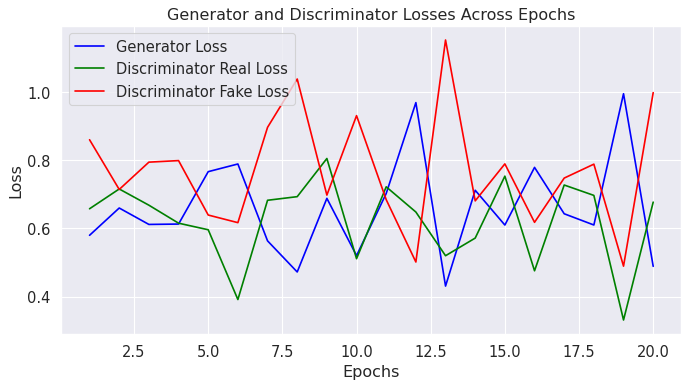

In [ ]:
total_epochs = [int(i+1) for i in range(EPOCHS)]
plt.figure(figsize=(10, 5))
plt.plot(total_epochs, gen_loss_list, label='Generator Loss', color='blue')
plt.plot(total_epochs, dis_loss_real_list, label='Discriminator Real Loss', color='green')
plt.plot(total_epochs, dis_loss_fake_list, label='Discriminator Fake Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses Across Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Good Scores (class = 2) Training

In [ ]:
class_id = 2
X_train = df_train.query("Credit_Score==@class_id").drop(columns=["Credit_Score", "Credit_Mix"]).values
scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
print(f"Original rows: {X_train.shape[0]}")

# Create an instance of the dataset
dataset_good = MyDataset(X_train)

# Create DataLoader
dataloader_good = DataLoader(dataset_good, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Original rows: 17828


In [ ]:
# Hyperparameters
BATCH_SIZE = 16
EPOCHS = 10
lr_gen = 1e-4
lr_dis = 1e-4

# Other params
noise_dim = 39
num_features = 39

def make_some_noise():
    return torch.randn(BATCH_SIZE,noise_dim)

generator_good = Generator(noise_dim, num_features)
discriminator_good = Discriminator(num_features)

criterion = nn.BCELoss()
gen_optimizer_good = torch.optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
disc_optimizer_good = torch.optim.Adam(discriminator.parameters(), lr=lr_dis, betas=(0.5, 0.999))

In [ ]:
gen_loss_list = []
dis_loss_real_list = []
dis_loss_fake_list = []

for epoch in range(EPOCHS):
  for batch in tqdm(dataloader_good, total=len(dataloader_good)):
    # Train Discriminator on real data
    disc_optimizer.zero_grad()
    real_labels = torch.ones(BATCH_SIZE, 1) * 0.9  # Label smoothing
    fake_labels = torch.zeros(BATCH_SIZE, 1) + 0.1  # Label smoothing

    dis_real_out = discriminator_good(batch)
    dis_real_loss = criterion(dis_real_out, real_labels)
    dis_real_loss.backward()

    # Train Discriminator on data produced by Generator
    inp_fake_x_gen = make_some_noise()
    dis_inp_fake_x = generator_good(inp_fake_x_gen).detach()
    dis_fake_out = discriminator_good(dis_inp_fake_x)
    dis_fake_loss = criterion(dis_fake_out, fake_labels)
    dis_fake_loss.backward()

    disc_optimizer.step()

    # Training Generator
    gen_optimizer.zero_grad()
    gen_inp = make_some_noise()
    gen_out = generator_good(gen_inp)
    dis_out_gen_training = discriminator(gen_out)
    gen_loss = criterion(dis_out_gen_training, real_labels)  # Use the same real_labels as above

    gen_loss.backward()
    gen_optimizer.step()

  print(f"Epoch {epoch}, D Loss Real: {dis_real_loss.item()}, D Loss Fake: {dis_fake_loss.item()}, G Loss: {gen_loss.item()}")
  gen_loss_list.append(gen_loss.item())
  dis_loss_real_list.append(dis_real_loss.item())
  dis_loss_fake_list.append(dis_fake_loss.item())

### Generated Data
Once GAN is trained, we generate new synthetic data from Generator. Here are the detailed steps and considerations:
- **Generate Synthetic Data**: Generate data using the trained generator
- **Inverse Transform**: Use the scaler's inverse transformation to bring the data back to the original scale
- **Convert Binary Variables**: For the binary variables, convert the values to either 0 or 1 based on a threshold

In [ ]:
class DataGenerator:
  def __init__(self, generator, scaler, num_cols, binary_cols, class_id: int):
    self.generator = generator
    self.scaler = scaler
    self.num_cols = num_cols
    self.binary_cols = binary_cols
    self.class_id = class_id


  def make_some_noise(self, n_rows):
    return torch.randn(n_rows, self.num_cols)


  def generate(self, n_rows):
    gen_inp = self.make_some_noise(n_rows)
    generated_data = self.generator(gen_inp).detach().numpy()
    generated_data = self.scaler.inverse_transform(generated_data)
    for col in self.binary_cols:
      generated_data[:, col] = (generated_data[:, col] > 0).astype(int)
    return generated_data, np.array([self.class_id for _ in range(generated_data.shape[0])])

In [ ]:
df_train_drop = df_train.drop(columns=["Credit_Score", "Credit_Mix"])
dummy_cols = ['Occupation', 'Payment_Behaviour']

binary_cols = []
for df_cols in df_train_drop:
  for c in dummy_cols:
    if c in df_cols:
      binary_cols.append(df_train_drop.columns.get_loc(df_cols))

New_X_train, New_y_train = df_train_drop.values , df_train["Credit_Score"]

synthetic_generator = DataGenerator(
    generator=generator,
    scaler=scalar,
    num_cols=New_X_train.shape[1],
    binary_cols=binary_cols,
    class_id=0,
)

In [ ]:
df_train["Credit_Score"].value_counts()[1]

53174

In [ ]:
n_rows = df_train["Credit_Score"].value_counts()[1] - df_train["Credit_Score"].value_counts()[0]
generated_data, synthetic_labels = synthetic_generator.generate(n_rows=n_rows)

In [ ]:
synthetic_labels.shape

(24176,)

In [ ]:
# Append generated data and labels
X_train_augmented = np.vstack((New_X_train, generated_data))
y_train_augmented = np.hstack((New_y_train, synthetic_labels))

### Comparing distributions

In [ ]:
df_train_augmented = pd.DataFrame(generated_data, columns=df_train_drop.columns)
df_train_augmented["Credit_Score"] = "Poor"

df_train_compare = df_train.drop(columns=["Credit_Mix"])
df_train_compare["Credit_Score"] = df_train_compare["Credit_Score"].map({0: "Poor", 1: "Standard", 2: "Good"})
original_poor = df_train_compare[df_train_compare['Credit_Score']=="Poor"]

In [ ]:
df_train_augmented["Interest_Rate"].value_counts()

Interest_Rate
28.792349    388
28.792345    143
28.792341     79
28.792337     49
28.792336     44
            ... 
11.319075      1
28.791307      1
28.508072      1
11.322077      1
28.404566      1
Name: count, Length: 21401, dtype: int64

In [ ]:
original_poor["Interest_Rate"]

56       15.0
57       15.0
58       15.0
59       15.0
63       15.0
         ... 
99994     7.0
99995     7.0
99996     7.0
99997    13.0
99999     7.0
Name: Interest_Rate, Length: 28998, dtype: float64

In [ ]:
df_train_augmented["Annual_Income"].value_counts()

Annual_Income
63743.496094    428
14058.967773    329
63743.261719    241
63743.031250    196
63742.566406    126
               ... 
50695.121094      1
14478.421875      1
63100.214844      1
62937.000000      1
37230.886719      1
Name: count, Length: 16860, dtype: int64

Feature: Annual_Income
ORIGINAL: count     28998.000000
mean      39297.533054
std       29223.862433
min        7005.930000
25%       16857.295000
50%       32276.420000
75%       56803.710000
max      152574.760000
Name: Annual_Income, dtype: float64
GENERATED: count    24176.000000
mean     38315.667969
std      21532.722656
min      14058.967773
25%      14782.340332
50%      36567.230469
75%      62783.186523
max      63743.496094
Name: Annual_Income, dtype: float64

  KS Test: statistic=0.1789, p-value=0.0000
  T-test: statistic=4.4525, p-value=0.0000
  Mann-Whitney U Test: statistic=344609657.0000, p-value=0.0008


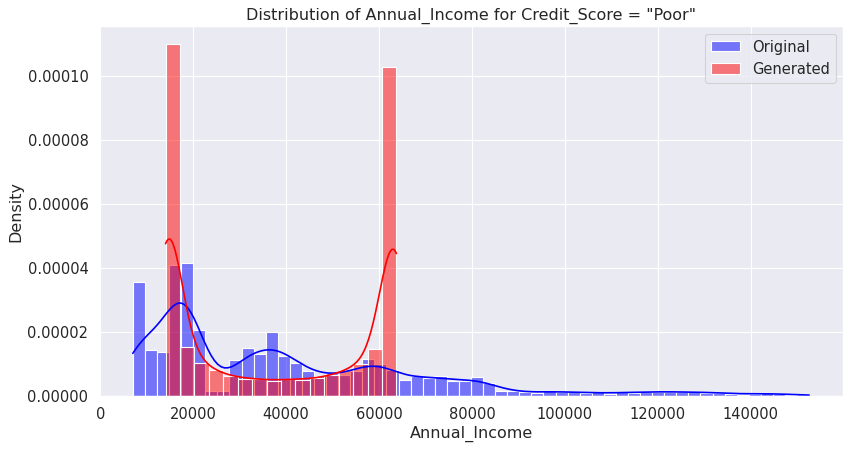

Feature: Interest_Rate
ORIGINAL: count    28998.000000
mean        20.032623
std          8.838582
min          1.000000
25%         15.000000
50%         21.000000
75%         27.000000
max         34.000000
Name: Interest_Rate, dtype: float64
GENERATED: count    24176.000000
mean        19.381557
std          7.545414
min         11.317335
25%         11.491993
50%         17.389529
75%         28.375566
max         28.792349
Name: Interest_Rate, dtype: float64

  KS Test: statistic=0.2094, p-value=0.0000
  T-test: statistic=9.1627, p-value=0.0000
  Mann-Whitney U Test: statistic=375007976.0000, p-value=0.0000


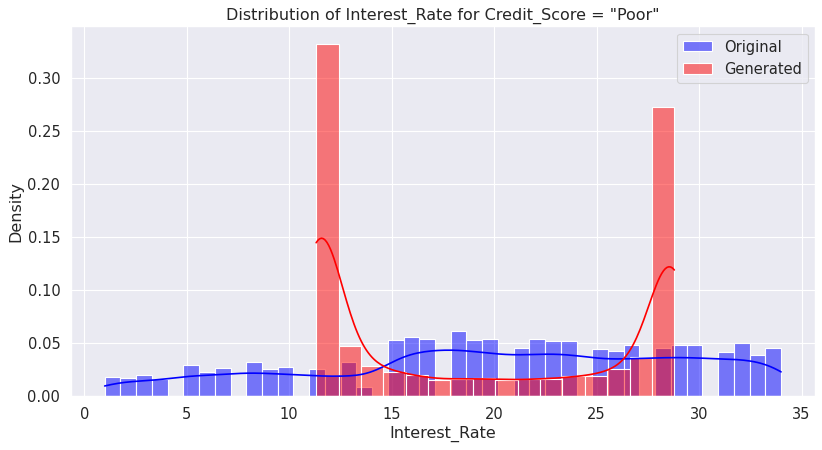

In [ ]:
FEATURES = ["Annual_Income", "Interest_Rate"]

for feature in FEATURES:  # Exclude 'Credit_Score'
    print(f"Feature: {feature}")
    print(f"ORIGINAL: {original_poor[feature].describe()}")
    print(f"GENERATED: {df_train_augmented[feature].describe()}")
    print()

    # Kolmogorov-Smirnov Test
    ks_stat, ks_pvalue = ks_2samp(original_poor[feature], df_train_augmented[feature])
    print(f"  KS Test: statistic={ks_stat:.4f}, p-value={ks_pvalue:.4f}")

    # T-test
    t_stat, t_pvalue = ttest_ind(original_poor[feature], df_train_augmented[feature], equal_var=False)
    print(f"  T-test: statistic={t_stat:.4f}, p-value={t_pvalue:.4f}")

    # Mann-Whitney U Test
    mw_stat, mw_pvalue = mannwhitneyu(original_poor[feature], df_train_augmented[feature])
    print(f"  Mann-Whitney U Test: statistic={mw_stat:.4f}, p-value={mw_pvalue:.4f}")

    # Plot distributions
    plt.figure(figsize=(12, 6))
    sns.histplot(original_poor[feature], color='blue', kde=True, label='Original', stat='density')
    sns.histplot(df_train_augmented[feature], color='red', kde=True, label='Generated', stat='density')
    plt.title(f'Distribution of {feature} for Credit_Score = "Poor"')
    plt.legend()
    plt.show()

## Train Model with Synthetic Data

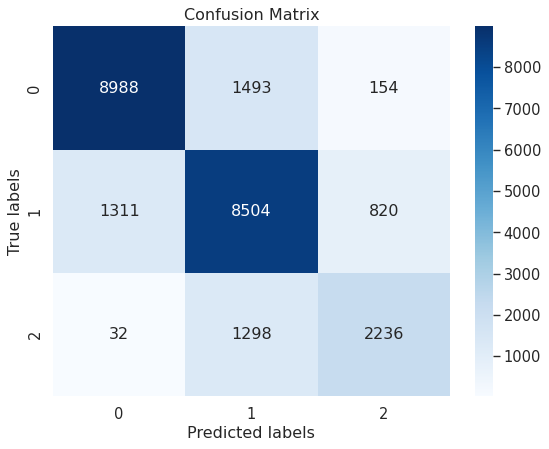

,0,1,2,accuracy,macro avg,weighted avg
precision,0.870003,0.752900,0.696573,0.794331,0.773159,0.794957
recall,0.845134,0.799624,0.627033,0.794331,0.757264,0.794331
f1-score,0.857388,0.775559,0.659976,0.794331,0.764308,0.794003
support,10635.000000,10635.000000,3566.000000,0.794331,24836.000000,24836.000000


In [ ]:
X_train_augmented, X_val_augmented, y_train_augmented, y_val_augmented = train_test_split(X_train_augmented, y_train_augmented, test_size=0.2, random_state=42,stratify=y_train_augmented)

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train_augmented)
X_train_augmented = scalar.transform(X_train_augmented)
X_val_augmented = scalar.transform(X_val_augmented)

res_augmented = dict()
model = XGBClassifier(n_jobs=-1)
model.fit(X_train_augmented, y_train_augmented)
y_pred_augmented = model.predict(X_val_augmented)

report_augmented = classification_report(y_val_augmented, y_pred_augmented, output_dict=True)
res_augmented["precision"] = report_augmented["weighted avg"]["precision"]
res_augmented["recall"] = report_augmented["weighted avg"]["recall"]
res_augmented["f1_score"] = report_augmented["weighted avg"]["f1-score"]
cm_augmented = confusion_matrix(y_val_augmented, y_pred_augmented)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_augmented, annot=True, cmap="Blues", fmt="d", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

report_df_augmented = pd.DataFrame(report_augmented)
report_df_augmented